<a href="https://colab.research.google.com/github/DarkSchneider/Exercises/blob/main/Traccia_progettoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512$\times$512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


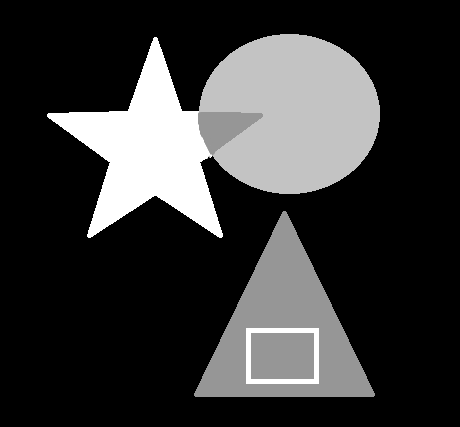


## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

In [ ]:
import matplotlib.pyplot as plt
from skimage import color, io, metrics
import sys
from google.colab import files


#lettura delle immagini e renderle in colormap bianco e nero
immagini=[]
for i in range(8):
  immagini.append(np.array(color.rgb2gray(plt.imread('{}.png'.format(i+1)))))

#aggiungere il blur
k1 = gaussian_kernel(5,0.5)
k2 = gaussian_kernel(7,1)
k3 = gaussian_kernel(9,1.3)

dim = immagini[i].shape

#filtro di blur
f1 = psf_fft(k1, 5, dim)
f2 = psf_fft(k2, 7, dim)
f3 = psf_fft(k3, 9, dim)


#rumore
sigma = 0.04

#moltiplicare tutto
imblur1 = []
imblur2 = []
imblur3 = []

for i in range(8):
    noise = np.random.normal(size=dim) * sigma
    imblur1.append(np.array(A(immagini[i], f1) + noise))
    imblur2.append(np.array(A(immagini[i], f2) + noise))
    imblur3.append(np.array(A(immagini[i], f3) + noise))

    #calcolare psnr e mse tra (immagini, imblur)
    PSNR = metrics.peak_signal_noise_ratio(immagini[i], imblur1[i])
    MSE = metrics.mean_squared_error(immagini[i], imblur1[i])
    print('PSNR immagine-{}: {}'.format(i,PSNR))
    print('MSE immagine-{}: {}'.format(i,MSE))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


PSNR immagine-0: 27.11368306453997
MSE immagine-0: 0.0019437110048383186
PSNR immagine-1: 27.44441759766381
MSE immagine-1: 0.0018011846626823868
PSNR immagine-2: 27.658741064867705
MSE immagine-2: 0.0017144542223752437
PSNR immagine-3: 27.752005496001402
MSE immagine-3: 0.0016780289547421408
PSNR immagine-4: 27.85074588306984
MSE immagine-4: 0.001640308032787984
PSNR immagine-5: 27.39549100638332
MSE immagine-5: 0.0018215911152763733
PSNR immagine-6: 27.527673659483614
MSE immagine-6: 0.0017669840693853892
PSNR immagine-7: 27.55460653685898
MSE immagine-7: 0.001756059982929773


## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [ ]:
from scipy.optimize import minimize
#filtro di blur attualmente utilizzato, cambiare questo per cambiare la A a seconda del blur che si vuole usare
blur = f3

if blur.all() == f3.all():
  set_number = 3
elif blur.all() == f2.all():
  set_number = 2
elif blur.all() == f1.all():
  set_number = 1
else:
  set_number = 99

#funzione per trovare i pollici partendo da pixel
def pixel2inch(num,dpi):
  return num/dpi

#ignoro il rumore

def f(x):
  x_matrix = x.reshape((immagini[0].shape[0], immagini[0].shape[1]))
  #print(0.5*np.linalg.norm(A(x_matrix,blur) - b))
  r = 0.5*(np.linalg.norm(A(x_matrix, blur) - b)**2)
  return np.sum(r)

def grad_f(x):
  x_matrix = x.reshape(immagini[0].shape[0], immagini[0].shape[0])  #formo la matrice
  r = AT(A(x_matrix,blur) - b, blur)
  r = r.reshape(r.shape[0]**2)
  return r

for i in range(8):
  b=imblur3[i]
  x0 = np.zeros(immagini[0].shape[0]**2)

  res = minimize(f, x0, method='CG', jac=grad_f, options={'disp':True, 'maxiter':30})

  print(res)

  x = res.x.reshape((512,512))
  
  psnr = metrics.peak_signal_noise_ratio(immagini[i], x)
'''
  plt.figure(figsize=(pixel2inch(512,72),pixel2inch(512,72))) #72dpi
  ax = plt.subplot()
  ax.imshow(x, cmap='gray', vmin=0, vmax=1)
  plt.title('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive'.format(set_number))
  plt.imsave('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number),x, cmap=plt.cm.gray, vmin=0, vmax=1)
  files.download('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number))
'''

         Current function value: 107.726708
         Iterations: 30
         Function evaluations: 64
         Gradient evaluations: 64
     fun: 107.72670795832187
     jac: array([-4.08891623e-04, -7.71525208e-04, -2.10942769e-05, ...,
       -1.65680040e-04,  2.59063522e-04, -1.08697632e-04])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 64
     nit: 30
    njev: 64
  status: 1
 success: False
       x: array([-0.32470165,  0.43265511, -0.48768199, ...,  0.17361815,
        0.2822678 , -0.32271996])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


         Current function value: 107.614254
         Iterations: 30
         Function evaluations: 64
         Gradient evaluations: 64
     fun: 107.61425399692388
     jac: array([ 0.00123727,  0.00015082, -0.00098546, ..., -0.00032436,
       -0.00070261, -0.00027145])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 64
     nit: 30
    njev: 64
  status: 1
 success: False
       x: array([-0.22407817,  0.2192681 ,  0.93217907, ...,  0.37396296,
       -0.46084733,  0.08063483])
         Current function value: 107.673885
         Iterations: 30
         Function evaluations: 64
         Gradient evaluations: 64
     fun: 107.67388487538453
     jac: array([ 0.00045198,  0.00153365,  0.00108818, ..., -0.00105925,
       -0.00260423, -0.00166034])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 64
     nit: 30
    njev: 64
  status: 1
 success: False
       x: array([-0.04540428, -0.77159148, -0.05493472, ...,  0.22967441,
        0.37823559

"\n  plt.figure(figsize=(pixel2inch(512,72),pixel2inch(512,72))) #72dpi\n  ax = plt.subplot()\n  ax.imshow(x, cmap='gray', vmin=0, vmax=1)\n  plt.title('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive'.format(set_number))\n  plt.imsave('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number),x, cmap=plt.cm.gray, vmin=0, vmax=1)\n  files.download('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number))\n"

## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [ ]:
#implementazione metodo del gradiente
#backtrackng
def next_step(x,grad): # backtracking procedure for the choice of the steplength
    alpha=1.1 
    rho = 0.5 #parametro con cui divido alpha dopo ogni iterazione
    c1 = 0.25 #parametro fisso
    p=-grad
    j=0
    jmax=10
    while (((f(x+alpha*p)).all() > (f(x)+c1*alpha*grad.T@p).all()) and j<jmax ): #condizioni di wolfe per la ricerca in linea inesatta
      alpha= rho*alpha
      j+=1
    if (j>jmax):
      return -1
    else:
      #print('alpha=',alpha)
      return alpha


'''
#metodo del gradiente
def grad_minimize(x0,b,mode,step,MAXITERATION,ABSOLUTE_STOP):
  #declare x_k and gradient_k vectors
  if mode=='plot_history':
    x=np.zeros((2,MAXITERATION))

  norm_grad_list=np.zeros((1,MAXITERATION))
  function_eval_list=np.zeros((1,MAXITERATION))
  error_list=np.zeros((1,MAXITERATION))
  
  #initialize first values
  x_last = np.array([x0[0],x0[1]])

  if mode=='plot_history':
    x[:,0] = x_last
  
  k=0

  function_eval_list[:,k]=f(x_last[0], x_last[1])
  error_list[:,k]=np.linalg.norm(x_last-b)
  norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  while (np.linalg.norm(grad_f(x_last))>ABSOLUTE_STOP and k < MAXITERATION ):
    k=k+1
    grad = grad_f(x_last) #direction is given by gradient of the last iteration

    # backtracking step
    step = next_step(x_last,grad)
    # Fixed step
    #step = 0.1
    
    if(step==-1):
      print('non convergente')
      return (k) #no convergence (iteration)

    x_last=x_last-step*grad
    if mode=='plot_history':
      x[:,k] = x_last

    function_eval_list[:,k]=f(x_last[0], x_last[1])
    error_list[:,k]=np.linalg.norm(x_last-b)
    norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  function_eval_list = function_eval_list[:,:k+1]
  error_list = error_list[:,:k+1]
  norm_grad_list = norm_grad_list[:,:k+1]
  
  print('iterations=',k)
  print('last guess: x=(%f,%f)'%(x[0,k],x[1,k]))
 
  #plots
  if mode=='plot_history':
    v_x0 = np.linspace(-5,5,500)
    v_x1 = np.linspace(-5,5,500)
    x0v,x1v = np.meshgrid(v_x0,v_x1)
    z = f(x0v,x1v)
    
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(v_x0, v_x1, z,cmap='viridis')
    ax.set_title('Surface plot')
    plt.show()

    # plt.figure(figsize=(8, 5))
    contours = plt.contour(x0v, x1v, z, levels=100)
    plt.plot(x[0,0:k],x[1,0:k],'*')
    #plt.axis([-5,5,-5,5])
    plt.axis ('equal')
    plt.show()
  return (x_last,norm_grad_list, function_eval_list, error_list, k)
'''

"\n#metodo del gradiente\ndef grad_minimize(x0,b,mode,step,MAXITERATION,ABSOLUTE_STOP):\n  #declare x_k and gradient_k vectors\n  if mode=='plot_history':\n    x=np.zeros((2,MAXITERATION))\n\n  norm_grad_list=np.zeros((1,MAXITERATION))\n  function_eval_list=np.zeros((1,MAXITERATION))\n  error_list=np.zeros((1,MAXITERATION))\n  \n  #initialize first values\n  x_last = np.array([x0[0],x0[1]])\n\n  if mode=='plot_history':\n    x[:,0] = x_last\n  \n  k=0\n\n  function_eval_list[:,k]=f(x_last[0], x_last[1])\n  error_list[:,k]=np.linalg.norm(x_last-b)\n  norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))\n\n  while (np.linalg.norm(grad_f(x_last))>ABSOLUTE_STOP and k < MAXITERATION ):\n    k=k+1\n    grad = grad_f(x_last) #direction is given by gradient of the last iteration\n\n    # backtracking step\n    step = next_step(x_last,grad)\n    # Fixed step\n    #step = 0.1\n    \n    if(step==-1):\n      print('non convergente')\n      return (k) #no convergence (iteration)\n\n    x_last=x_last

In [22]:
#altra iterazione per gradient_minimize
def grad_minimize(x0, b, step, MAXITERATION, ABSOLUTE_STOP):
  #declare x_k and gradient_k vectors

  norm_grad_list=np.zeros((1,MAXITERATION+1))
  function_eval_list=np.zeros((1,MAXITERATION+1))
  error_list=np.zeros((1,MAXITERATION+1))
  
  #initialize first values
  x_last = x0.reshape((immagini[0].shape[0], immagini[0].shape[1]))


  k=0

  function_eval_list[:,k]=f(x_last)
  error_list[:,k]=np.linalg.norm(x_last-b)
  norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  while (np.linalg.norm(grad_f(x_last))>ABSOLUTE_STOP and k < MAXITERATION ):
    k=k+1
    grad = grad_f(x_last) #direction is given by gradient of the last iteration

    # backtracking step
    step = next_step(x_last,grad)
    # Fixed step
    #step = 0.1
    
    if(step==-1):
      print('non convergente')
      return (k) #no convergence (iteration)

    x_last=x_last-step*grad

    function_eval_list[:,k]=f(x_last)
    error_list[:,k]=np.linalg.norm(x_last-b)
    norm_grad_list[:,k]=np.linalg.norm(grad_f(x_last))

  function_eval_list = function_eval_list[:,:k+1]
  error_list = error_list[:,:k+1]
  norm_grad_list = norm_grad_list[:,:k+1]
  
  print('iterations=',k)
  #print('last guess: x=(%f)'%(x[0,k]))

  return (x_last,norm_grad_list, function_eval_list, error_list, k)


In [ ]:
lam=0.8

def f(x):
  if x.shape != immagini[0].shape:
    x_matrix = x.reshape((immagini[0].shape[0], immagini[0].shape[1]))
  else:
    x_matrix = x
  r = 0.5*(np.linalg.norm(A(x_matrix, blur) - b)**2) + ((lam/2)*np.linalg.norm(x_matrix)**2)
  return np.sum(r)

def grad_f(x):
  if x.shape != immagini[0].shape:
    x_matrix = x.reshape(immagini[0].shape[0], immagini[0].shape[0])  #formo la matrice
  else:
    x_matrix = x
  r = AT(A(x_matrix,blur), blur) - AT(b, blur) + lam*x_matrix
  #r = r.reshape(r.shape[0]**2)
  return r

#funzione alternativa
listaValFunG = []
listaErrRelG = []
listaPSNRG= []
listaValGradG = []

m = 512
n = 512

def gradient_minimize(B, labda=0, maxit=19, abstop = 1.e-6):
  x_last = np.zeros(dim)
  k=0
  while (np.linalg.norm(grad_f(x_last, B, labda)) > abstop and k < maxit):
    k=k+1
    grad = grad_f(x_last, B)
    step = next_step(x_last, grad, B, labda)

    listaValFunG.append(f(x_last, B))
    x_last = x_last- step * grad

    listaValGradG.append(np.linalg.norm(grad.reshape(m,n), "fro"))
    listaErrRelG.append(np.linalg.norm(x_last.reshape(m,n) - x_matrix, "fro") / np.linalg.norm(x_matrix, "fro"))
    listaPSNRG.append(metrics.peak_signal_noise_ratio(x_matrix, x_last.reshape(m,n)))
    return x_last


iterations= 100
[[ 0.00595383  0.00451533 -0.00092045 ... -0.01014485 -0.00139174
   0.00441908]
 [-0.00411286 -0.00406824 -0.00689335 ... -0.01387868 -0.01243156
  -0.00731366]
 [-0.01203594 -0.00697175 -0.00224649 ... -0.01452593 -0.01837271
  -0.0163842 ]
 ...
 [-0.00333196 -0.00580314 -0.0079971  ... -0.0067035  -0.0034601
  -0.00169314]
 [ 0.00567733  0.00363416  0.00262658 ... -0.0037263   0.00407442
   0.00794118]
 [ 0.01003249  0.0091513   0.00664916 ... -0.00482486  0.00582695
   0.01059134]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iterations= 100
[[-0.00285417  0.00677144  0.01681418 ...  0.01439785  0.00423416
  -0.00217941]
 [ 0.00367211  0.00687766  0.01008163 ...  0.00972529  0.00400568
   0.00353674]
 [ 0.0091533   0.0060656   0.00095439 ...  0.00156798 -0.00061591
   0.00563342]
 ...
 [-0.0050615  -0.01055197 -0.00974396 ... -0.01585299 -0.01112456
  -0.0031458 ]
 [-0.0098522  -0.01248208 -0.00805716 ... -0.00834968 -0.00983898
  -0.00660438]
 [-0.0097894  -0.00311312  0.00741944 ...  0.00643328 -0.00280637
  -0.0076057 ]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iterations= 100
[[ 0.00416357 -0.0034517  -0.00967026 ... -0.0040315   0.00090915
   0.00555798]
 [ 0.00855049  0.00172753 -0.01148811 ... -0.00832997 -0.00601084
   0.00262384]
 [ 0.01008813  0.00989213 -0.00586249 ... -0.01052232 -0.01100395
  -0.00212567]
 ...
 [-0.00671558 -0.00322156 -0.00735734 ... -0.00026758 -0.00521939
  -0.00958869]
 [-0.00333102 -0.00269395 -0.00540879 ...  0.00316047  0.00033031
  -0.00369765]
 [ 0.00055836 -0.00229922 -0.00417598 ...  0.00175438  0.00433231
   0.00313677]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iterations= 100
[[ 0.01176582  0.00911734  0.00793958 ...  0.0055097   0.01592406
   0.01544758]
 [ 0.01186409  0.00934413  0.00970628 ...  0.00470323  0.01664579
   0.016272  ]
 [ 0.00504684  0.00334855  0.00583152 ...  0.00166407  0.01045698
   0.00929452]
 ...
 [-0.00217115 -0.002508   -0.00266305 ...  0.0020275  -0.00417427
  -0.00442025]
 [-0.00213573 -0.00208441 -0.0022886  ...  0.00208377 -0.00286451
  -0.00382936]
 [ 0.00492429  0.00398371  0.00229109 ...  0.00400063  0.00583728
   0.00492529]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iterations= 100
[[-0.00830881 -0.01072144 -0.01189562 ...  0.01419452  0.00750908
  -0.00389488]
 [-0.0066766  -0.01169612 -0.01440589 ...  0.01563458  0.0114818
   0.00048458]
 [-0.01063873 -0.0165392  -0.01701065 ...  0.0103499   0.01256997
   0.00122012]
 ...
 [ 0.01597659  0.01963999  0.0134758  ... -0.00358364 -0.00032775
   0.00425175]
 [ 0.0081108   0.00952625  0.00475371 ...  0.0005335   0.00207825
   0.00154949]
 [-0.00329789 -0.00369083 -0.00545324 ...  0.00673956  0.00402795
  -0.0030236 ]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iterations= 100
[[ 0.01641623  0.00764591  0.00083234 ...  0.00715794  0.00702655
   0.01436933]
 [ 0.01380185  0.00229002 -0.0096154  ...  0.00852001  0.00388882
   0.01029488]
 [ 0.01288518  0.0050275  -0.006621   ...  0.00193867  0.00041631
   0.00745287]
 ...
 [ 0.01637489  0.02167759  0.01015567 ... -0.00975208 -0.00780747
   0.00362905]
 [ 0.01459446  0.02000552  0.01528559 ... -0.00657344 -0.00058047
   0.00734953]
 [ 0.01725769  0.01613125  0.0137218  ...  0.00057077  0.00678372
   0.01435276]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iterations= 100
[[ 0.0002836  -0.00542545  0.00023249 ...  0.00134363  0.00750072
   0.00928377]
 [-0.0055184  -0.01178589 -0.0053457  ...  0.00634099  0.01533371
   0.01060294]
 [-0.01294066 -0.01533064 -0.0083245  ...  0.0076018   0.01233782
   0.00280382]
 ...
 [ 0.01143689  0.00498325  0.00405012 ...  0.00703545  0.00537806
   0.01067563]
 [-0.00084087 -0.00504861 -0.00026827 ... -0.00481585 -0.00515228
   0.00046275]
 [-0.00386934 -0.00686819  0.00046784 ... -0.00519504 -0.00477159
  -0.0006917 ]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iterations= 100
[[-0.00043113 -0.00300071  0.00092866 ... -0.01060963 -0.00387378
   0.00190919]
 [ 0.01459696  0.01302394  0.00849385 ... -0.00297154  0.00443516
   0.01277139]
 [ 0.01080179  0.01076097  0.00463037 ...  0.00206517  0.00786479
   0.0112113 ]
 ...
 [-0.00792738 -0.02137009 -0.02069749 ... -0.00481538 -0.00582344
  -0.00316175]
 [-0.0152352  -0.02987443 -0.02540665 ... -0.00380258  0.00020877
  -0.00171771]
 [-0.01509568 -0.02401892 -0.0164755  ... -0.00960721 -0.00277912
  -0.00331806]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

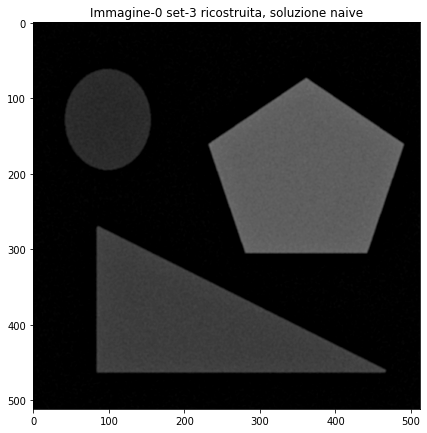

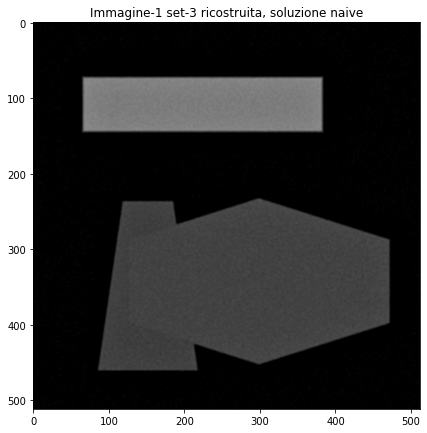

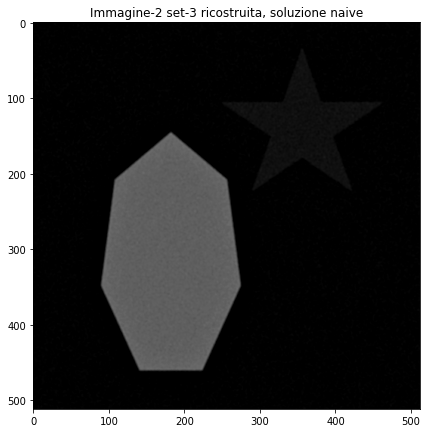

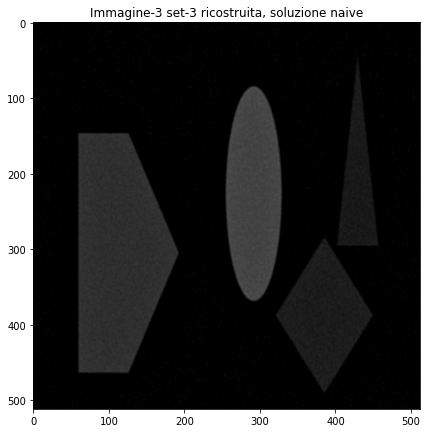

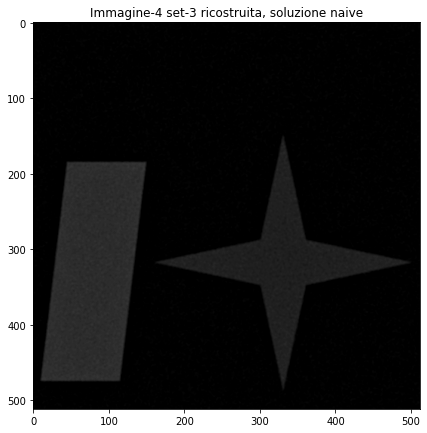

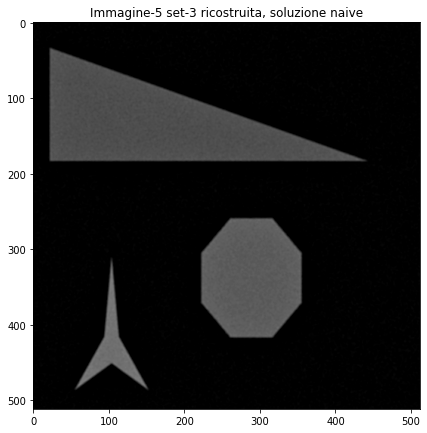

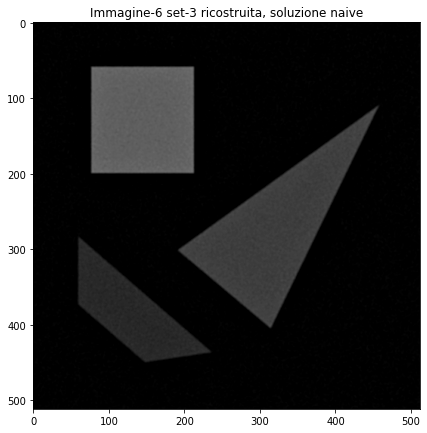

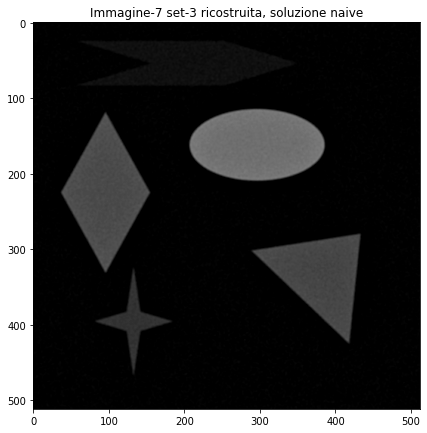

In [23]:
'''
for i in range(8):
  b=imblur3[i]
  x0 = np.zeros(immagini[0].shape[0]**2)

  reg = minimize(f, x0, method='CG', jac=grad_f)

  print(reg)

  x = reg.x.reshape((512,512))

  plt.figure(figsize=(8,8))
  ax = plt.subplot()
  ax.imshow(x, cmap='gray', vmin=0, vmax=1)
  plt.title('Immagine-' + str(i) + ' set-{} ricostruita, lambda=%d'.format(set_number) % (lam))
  plt.savefig('Immagine-' + str(i) + ' set-{} ricostruita, lambda=%d'.format(set_number) % (lam))
  files.download('Immagine-' + str(i) + ' set-{} ricostruita, lambda=%d.png'.format(set_number) % (lam))
  '''
#soluzione con il metodo del gradiente
step=0.1
MAXITERATIONS=100
ABSOLUTE_STOP=1.e-5
mode='plot_history'
x0 = np.zeros(immagini[0].shape[0]**2)
for i in range(8):
  b = imblur1[i]
  X, norm_grad_list, function_eval_list, error_list, k  = grad_minimize(x0, b, step, MAXITERATIONS, ABSOLUTE_STOP)

  print(X)
  
  psnr = metrics.peak_signal_noise_ratio(immagini[i], X)

  plt.figure(figsize=(pixel2inch(512,72),pixel2inch(512,72))) #72dpi
  ax = plt.subplot()
  ax.imshow(X, cmap='gray', vmin=0, vmax=1)
  plt.title('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive'.format(set_number))
  plt.imsave('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number),X, cmap=plt.cm.gray, vmin=0, vmax=1)
  files.download('Immagine-' + str(i) + ' set-{} ricostruita, soluzione naive.png'.format(set_number))


#(x_last,norm_grad_list, function_eval_list, error_list, k)= grad_minimize(x0, b, mode,step,MAXITERATIONS, ABSOLUTE_STOP)
#x_last = gradient_minimize(x0)

## 4) Variazione Totale (Facoltativo) 

Un altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [ ]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

